In [1]:
import sys
import pandas as pd
import numpy as np
import os
import operator
import string
import re
import random
import warnings
warnings.filterwarnings('ignore')
import platform
import json, pickle
from collections import defaultdict

import sklearn as sk
from sklearn.utils import check_random_state
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

from statsmodels.stats.outliers_influence import variance_inflation_factor
from bayes_opt import BayesianOptimization

import optuna

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem import AllChem, rdDepictor, MolFromSmiles, Descriptors, rdMolDescriptors, Crippen, QED, EState, Lipinski, MolSurf, Fragments

import deepchem as dc
from deepchem.feat.molecule_featurizers import MolGraphConvFeaturizer
from deepchem.feat import RDKitDescriptors

# 시각화 라이브러리
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
import catboost as cat
import lightgbm as lgb

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
CFG = {'SEED' : 42,}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    check_random_state(seed)

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
train_mlm = pd.read_csv('./Data/eda/mlm_or.csv')
train_hlm = pd.read_csv('./Data/eda/hlm_or.csv')
test = pd.read_csv('./Data/test.csv')

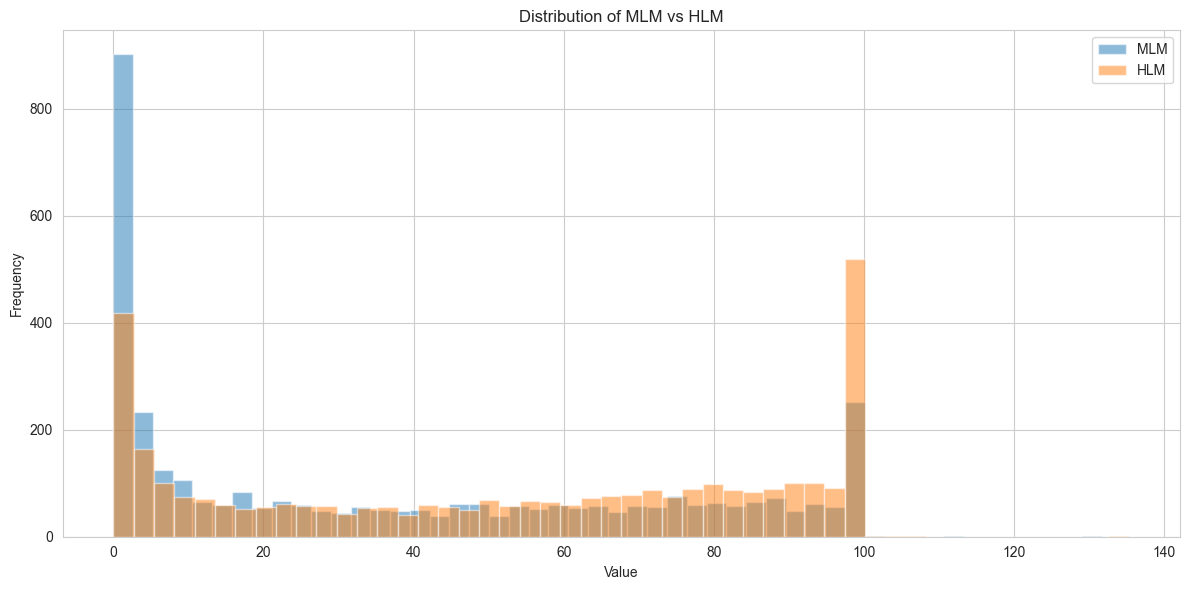

,MLM,HLM
count,3498.000000,3498.000000
mean,37.384742,53.090206
std,35.695993,36.080081
min,0.000000,0.000000
25%,2.433000,15.905500
50%,26.193000,58.023000
75%,70.807250,87.753000
max,131.720000,135.336000


In [10]:
# 겹쳐보기 + 기술통계 -> MLM 평균보다 HLM 평균이 더 크다
desc_stats = train[['MLM', 'HLM']].describe()

# Plot histograms for MLM and HLM
plt.figure(figsize=(12, 6))

plt.hist(train['MLM'], bins=50, alpha=0.5, label='MLM')
plt.hist(train['HLM'], bins=50, alpha=0.5, label='HLM')

plt.title('Distribution of MLM vs HLM')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

desc_stats

In [ ]:
len(train_hlm.columns.to_list())

['MLM',
 'HLM',
 'AlogP',
 'Molecular_Weight',
 'Num_H_Acceptors',
 'Num_H_Donors',
 'Num_RotatableBonds',
 'LogD',
 'Molecular_PolarSurfaceArea',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'EState_VSA10',
 'EState_VSA4',
 'EState_VSA7',
 'EState_VSA8',
 'EState_VSA9',
 'ExactMolWt',
 'FractionCSP3',
 'HallKierAlpha',
 'HeavyAtomCount',
 'HeavyAtomMolWt',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'MolLogP',
 'MolMR',
 'MolWt',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAromaticCarbocycles',
 'NumAromaticRings',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'NumValenceElectrons',
 'PEOE_VSA13',
 'PEOE_VSA2',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA9',
 'RingCount',
 'SMR_VSA10',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA7',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA5',
 'SlogP_VSA6',
 '

In [14]:
# 기타 칼럼 값 분포 살펴보기
sns.set_style("whitegrid")
plt.figure(figsize=(18, 12))

# Subplots for each feature
features = train_hlm.columns.to_list()
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_hlm[feature], bins=50, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

ValueError: num must be an integer with 1 <= num <= 9, not 10

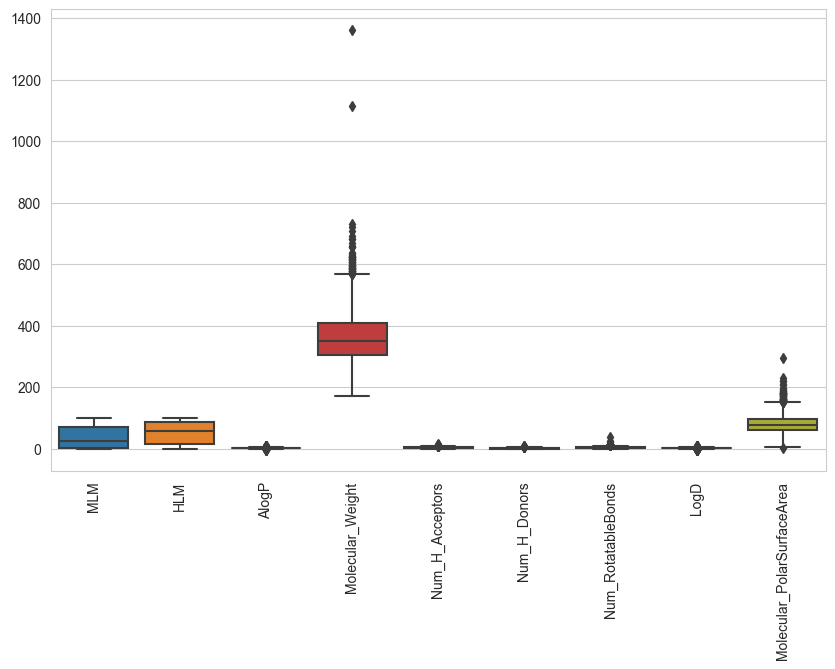

In [15]:
# Box plot -> 이상치가 조금 보인다
plt.figure(figsize=(10, 6))
sns.boxplot(data=train)
plt.xticks(rotation=90)
plt.show()

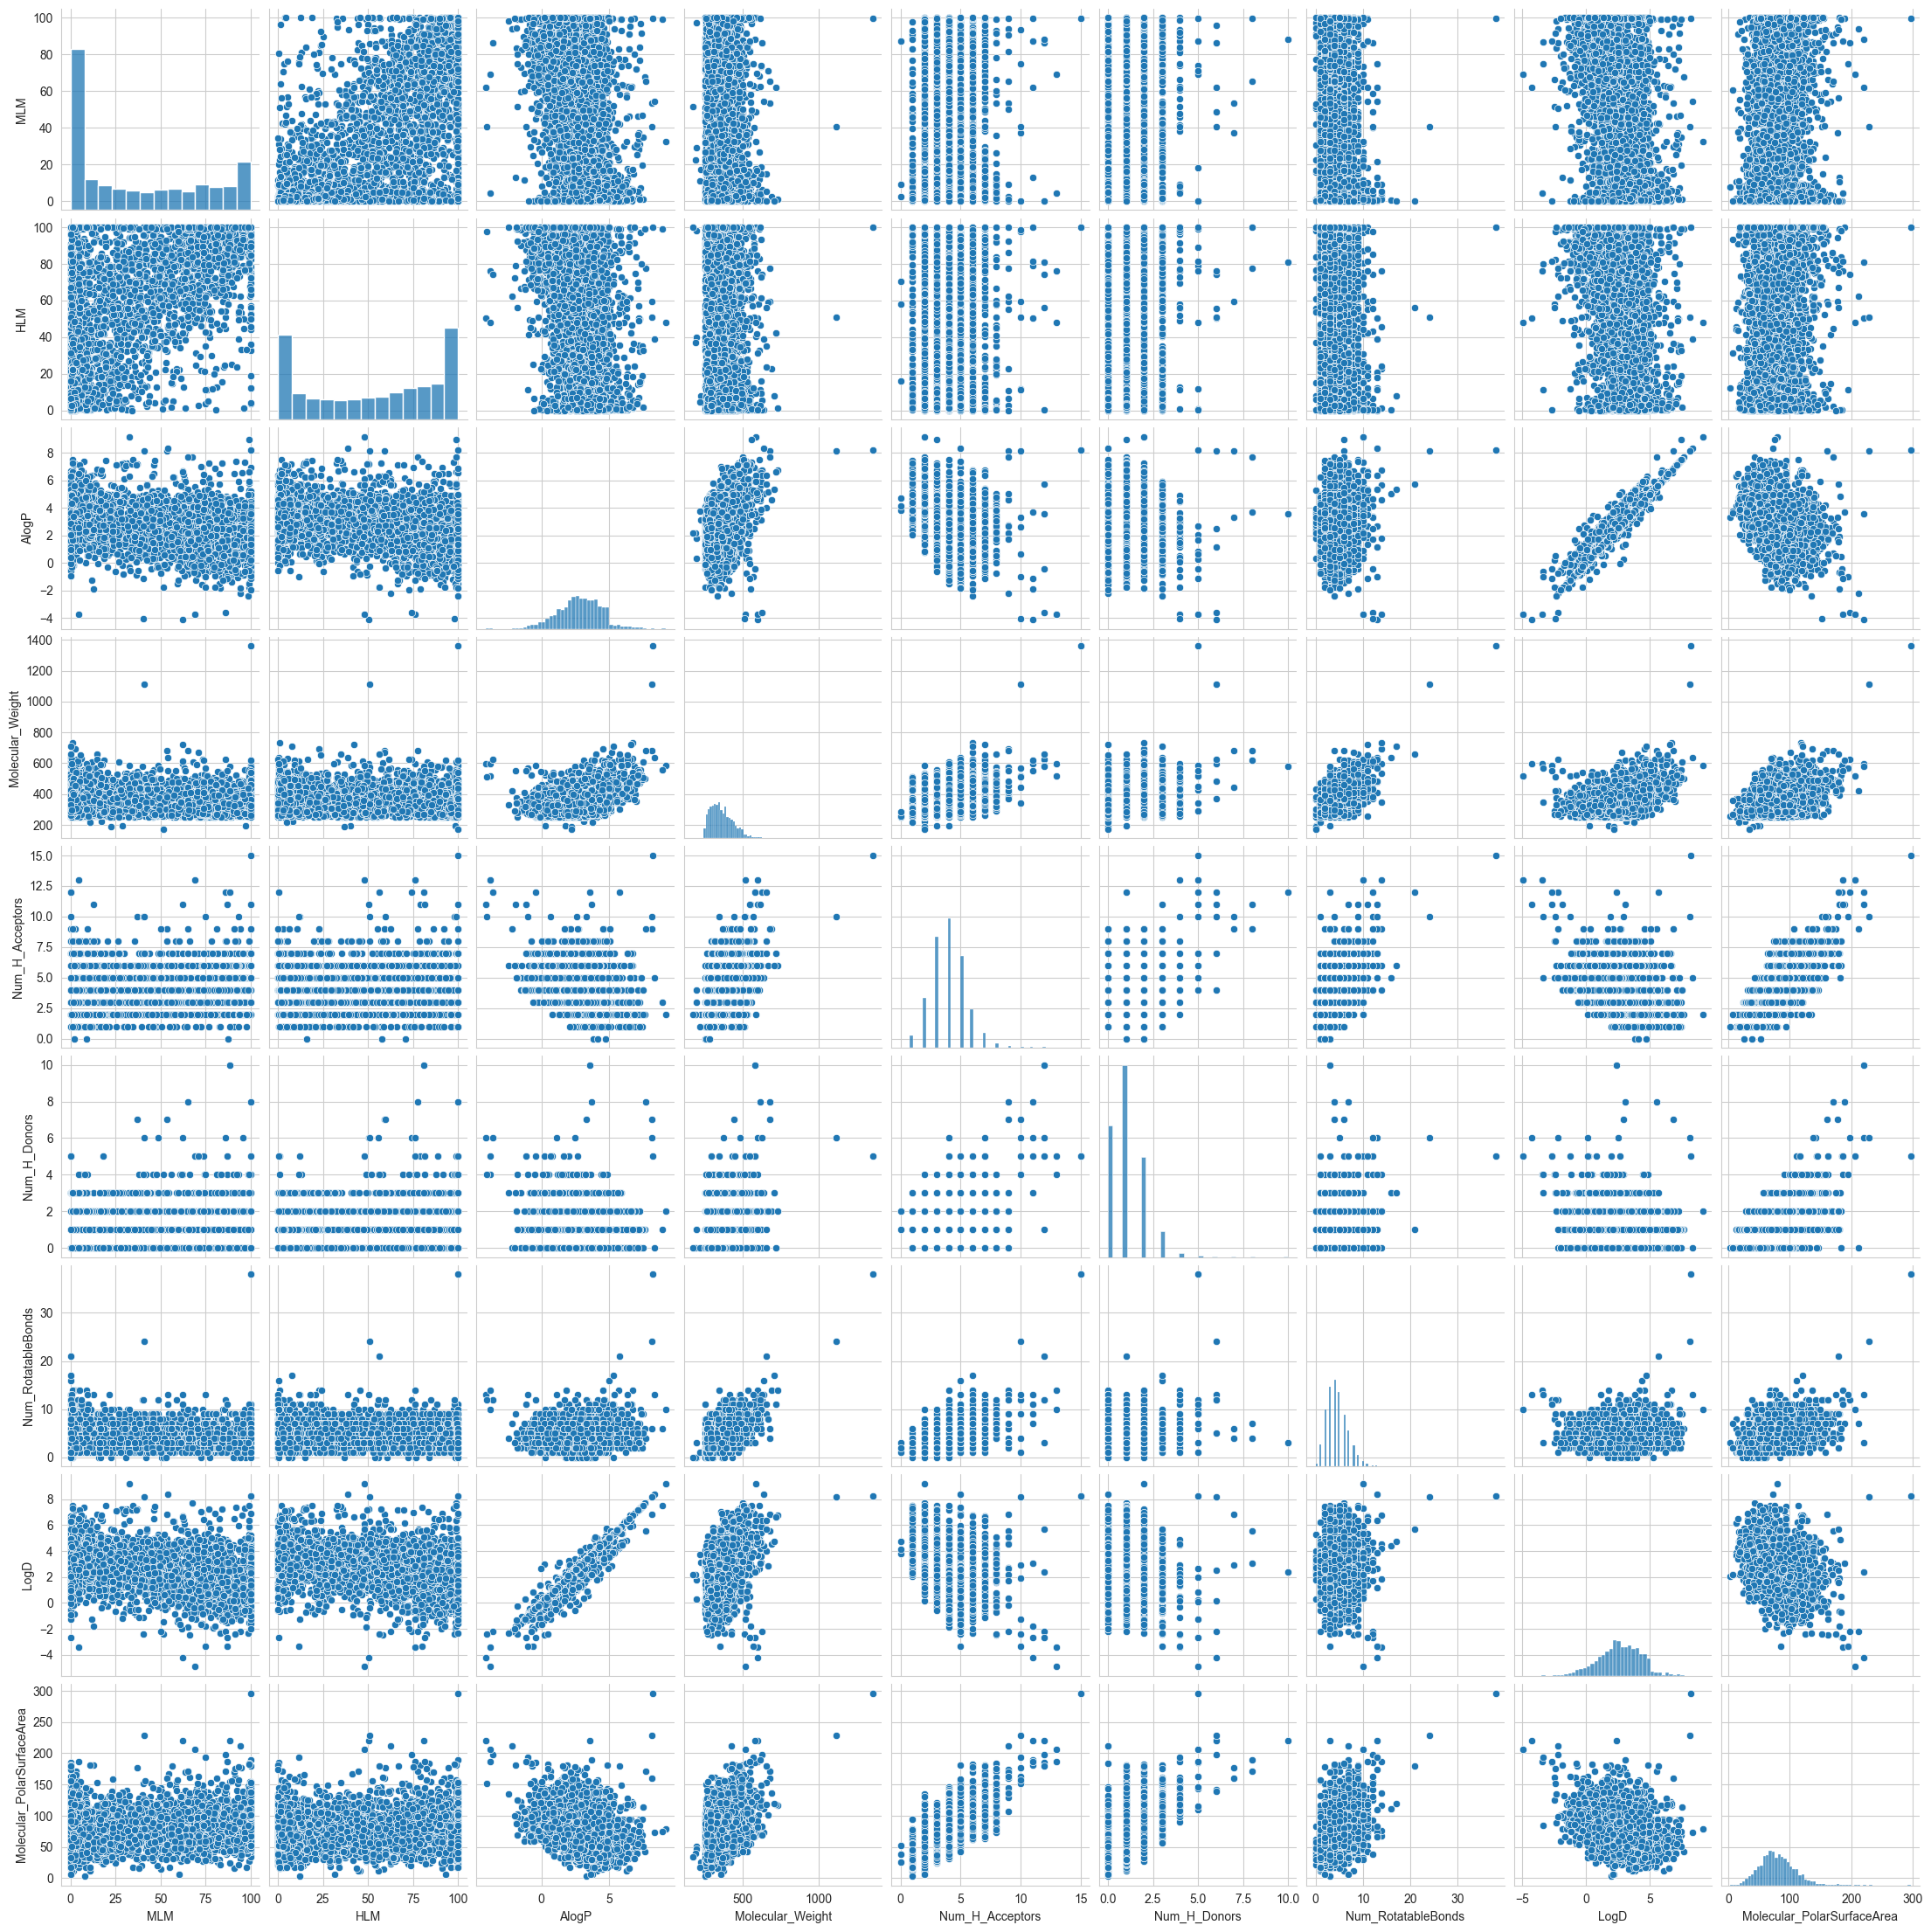

In [16]:
# Scatter plot matrix -> alogP랑 logD가 거의 양의 상관관계를 가짐
sns.pairplot(train)
plt.show()

In [17]:
# SMILES 열의 데이터를 가져와서 각 문자열의 길이 계산
smiles_lengths = train['SMILES'].str.len()

# 최대 및 최소 길이 확인
min_length = smiles_lengths.min()
max_length = smiles_lengths.max()
min_length_idx = smiles_lengths.idxmin()
max_length_idx = smiles_lengths.idxmax()

min_length, min_length_idx, max_length, max_length_idx

(18, 1399, 174, 1172)

In [18]:
train.iloc[1399]

id                                                 TRAIN_1406
SMILES                        COCCN(Cc1ccn(C)c(=O)c1)Cc1cccs1
MLM                                                     0.047
HLM                                                     0.075
AlogP                                                   1.108
Molecular_Weight                                      292.396
Num_H_Acceptors                                             3
Num_H_Donors                                                0
Num_RotatableBonds                                          7
LogD                                                    1.066
Molecular_PolarSurfaceArea                              61.02
Name: 1406, dtype: object

In [19]:
train.iloc[1172]

id                                                                 TRAIN_1179
SMILES                        CCc1c(C)nc2cc(-c3cc(OC)cc(OC)c3)nn2c1NCCN(CC)CC
MLM                                                                      2.87
HLM                                                                     30.63
AlogP                                                                   4.426
Molecular_Weight                                                       411.54
Num_H_Acceptors                                                             5
Num_H_Donors                                                                1
Num_RotatableBonds                                                         10
LogD                                                                    2.888
Molecular_PolarSurfaceArea                                              63.92
Name: 1179, dtype: object

In [20]:
# EDA_df 데이터의 SMILES에 있는 분자 알아보기
unique_atoms = set()
for smiles in train['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        unique_atoms.add(atom.GetSymbol())

print(unique_atoms)

{'F', 'N', 'Cl', 'Br', 'S', 'C', 'O', 'I', 'Se'}


In [21]:
# 원래 SMILES 문자열에는 수소를 명시적으로 표현하지 않지만, 표현하는 경우도 있음(아미노기, 아미드, 방향족 질소 원자에 붙은 수소원자, 일부러 명시적으로 표시 등)
# 그런 부분을 제외하고, 유효하지 않은 화합물이 있는지 확인하기 위한 위한 함수 불러옴 -> 없음.
allowed_atoms = ["I", "O", "F", "Br", "Se", "C", "N", "Cl", "S", "He", "H"]

def contains_only_allowed_atoms(smiles):
    for atom in allowed_atoms:
        smiles = smiles.replace(atom, "")
    return all(char.islower() or char in ['.', '-', '=', '#', '$', '(', ')', '+', '--', '[', ']', '@', '%', ':', '/', '\\', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] for char in smiles)


# Check if the SMILES contains only the allowed atoms and filter invalid ones
invalid_smiles = train[~train['SMILES'].apply(contains_only_allowed_atoms)]

invalid_smiles_count = len(invalid_smiles)
invalid_smiles_examples = invalid_smiles.head()

invalid_smiles_count, invalid_smiles_examples[['id', 'SMILES']]

(0,
 Empty DataFrame
 Columns: [id, SMILES]
 Index: [])

In [22]:
# 중복값에 대한 주최측의 답변

'''
본 데이터는 생물학적 재료를 활용한 실험으로써,
동일 실험 조건이라도 실험 결과는 대사효소의 활성 정도나 반응 시간의 미세한 차이 등 여러가지 요인들에 편차가 발생합니다.
데이터의 신뢰성 확보를 위해, 제공된 대사안정성 데이터 값은 각각 n수를 3으로 하여 평균을 냈으며
MLM에서는 5% 이내, HLM에서는 10% 이내의 값이 나오는지 확인하였으므로, 편차는 제공하지 않습니다.
몇몇 데이터는 실험적 오차가 발생한 것으로 예측됩니다.
중복 값은 배치가 다른 실험에 대한 값입니다.
각 배치마다 reference 물질을 사용하여 확인하였으므로 실험계 전체의 오류는 없으나 batch 중 한 실험은 오류가 있는 것으로 예측되고, 
그와 같은 데이터가 포함될 가능성은 항상 있으므로 그러한 데이터의 처리가 중요하여 경진대회에 포함하였습니다.
'''

duplicate_smiles = train['SMILES'].duplicated(keep=False)
duplicates = train[duplicate_smiles].sort_values(by='SMILES')
duplicates

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
451,TRAIN_0451,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
543,TRAIN_0543,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
366,TRAIN_0366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
837,TRAIN_0837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
1085,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,23.630,71.470,1.684,381.450,7,1,4,1.684,126.52
2848,TRAIN_2848,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
2096,TRAIN_2096,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,1.880,61.280,2.843,360.490,3,0,4,2.843,49.85
1666,TRAIN_1666,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,5.494,25.397,2.843,360.490,3,0,4,2.843,49.85


In [23]:
# 중복값의 각 편차가 30이 넘으면 둘 다 제거, 아니면 최대값으로(안정적인 값)
indices_to_keep = []
indices_to_drop = []

# Iterate over the 'duplicates' dataframe with a step of 2 (since they are pairs)
for i in range(0, len(duplicates), 2):
    row1 = duplicates.iloc[i]
    row2 = duplicates.iloc[i + 1]
    
    # Calculate the difference in the absolute differences for the pair
    diff_of_MLM = abs(row1['MLM'] - row2['MLM'])
    diff_of_HLM = abs(row1['HLM'] - row2['HLM'])
    
    # If the difference in the absolute differences is greater than 30, drop both rows
    if diff_of_MLM > 30 or diff_of_HLM > 30:
        indices_to_drop.extend([row1.name, row2.name])
    else:
        # Otherwise, keep one row with maximum MLM and HLM values
        max_MLM = max(row1['MLM'], row2['MLM'])
        max_HLM = max(row1['HLM'], row2['HLM'])
        
        # Update the MLM and HLM values of the first row of the pair with the maximum values
        duplicates.at[row1.name, 'MLM'] = max_MLM
        duplicates.at[row1.name, 'HLM'] = max_HLM
        
        # Keep the first row and drop the second row of the pair
        indices_to_keep.append(row1.name)
        indices_to_drop.append(row2.name)

# Filter out the rows from 'duplicates' dataframe
filtered_duplicates = duplicates.loc[indices_to_keep]

filtered_duplicates

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
366,TRAIN_0366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
1085,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
859,TRAIN_0859,CCCCC/N=c1\n(C)c(=O)nc2sccn12,2.860,37.769,2.484,252.336,4,0,4,2.474,73.56
565,TRAIN_0565,CCOC(=O)CC1(NC(=O)N2Cc3c(sc4c3CCCC4)-n3cccc3C2...,5.884,5.540,6.727,537.736,3,1,6,6.727,120.05
1914,TRAIN_1914,COC(=O)C1(CCCN(C)CCc2ccc(OC)c(OC)c2)CCCc2c1ccc...,12.690,17.971,5.374,485.612,7,0,13,3.870,66.46
2097,TRAIN_2097,COc1ccc(C2=NOC(c3ccc(-c4nnn[nH]4)cc3)C2)cc1,72.473,21.930,2.235,321.333,6,1,4,1.806,85.28
2805,TRAIN_2805,COc1ccc(C2=NOC(c3ccsc3)C2)cc1,8.144,11.348,2.868,259.324,3,0,3,2.868,59.06
2081,TRAIN_2081,COc1ccc([C@H]2Oc3cc(OC)cc(OC)c3C[C@H]2O)cc1,0.829,7.530,2.940,316.348,5,1,4,2.940,57.15


In [24]:
# Remove the original duplicates from the train dataframe
train = train.drop(indices_to_drop)

# Append the processed duplicates to the train dataframe
train = pd.concat([train, filtered_duplicates])

# Sort the dataframe by index for consistency
train.reset_index(inplace=True, drop=True)

train.head(10)

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43
5,TRAIN_0005,COc1c(F)c(F)cc2c(=O)c(C(=O)NCCCN3CCCC3=O)cn(C3...,27.640,66.630,1.335,419.422,4,1,7,1.335,78.95
6,TRAIN_0006,CN(C)c1cccc2c(S(=O)(=O)NC(CC(=O)O)C(=O)O)cccc12,82.107,69.250,1.954,547.707,7,4,9,0.464,144.42
7,TRAIN_0007,C1=Cn2nc(/C=C/c3cccs3)nc2-c2ccccc2O1,2.673,25.121,2.967,293.343,3,0,2,2.967,68.18
8,TRAIN_0008,COc1ccc2nc(C3=CCCN(C)C3)n(C)c2c1,74.519,71.471,-0.946,347.366,7,2,3,-0.723,104.89
9,TRAIN_0009,CCN1CCCC1CNC(=O)C1CCCN(c2ncnc3[nH]cnc23)C1,73.417,76.291,1.259,357.453,5,2,5,-0.373,90.04


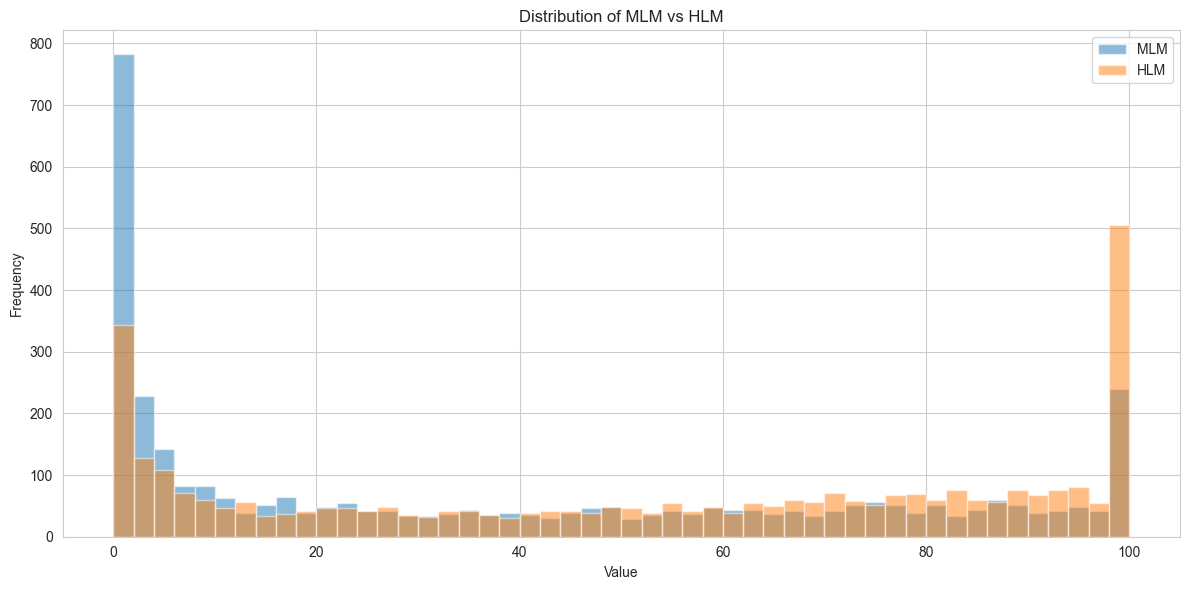

,MLM,HLM
count,3456.000000,3456.000000
mean,37.513959,53.391561
std,35.622812,35.890992
min,0.000000,0.000000
25%,2.560750,16.739750
50%,26.632000,58.397000
75%,70.990750,87.800500
max,100.000000,100.000000


In [25]:
# 다시 타겟값 살펴보기
desc_stats = train[['MLM', 'HLM']].describe()

# Plot histograms for MLM and HLM
plt.figure(figsize=(12, 6))

plt.hist(train['MLM'], bins=50, alpha=0.5, label='MLM')
plt.hist(train['HLM'], bins=50, alpha=0.5, label='HLM')

plt.title('Distribution of MLM vs HLM')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

desc_stats

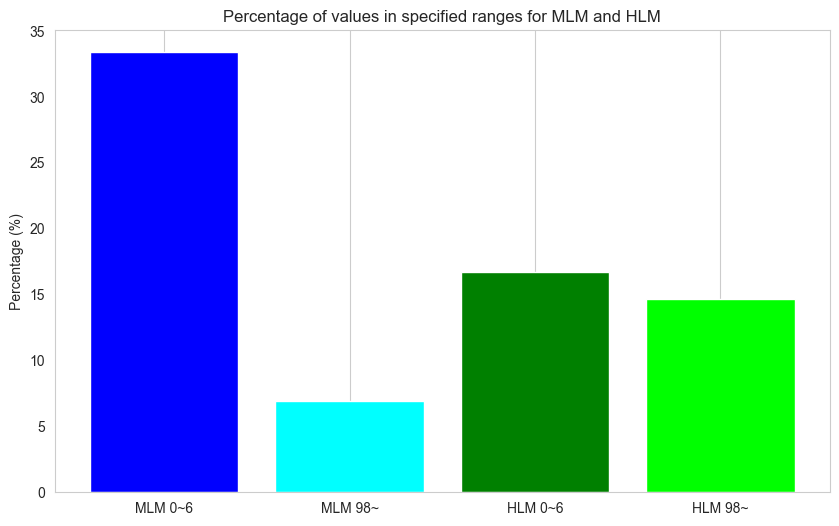

In [26]:
# 특정 값에 속하는 MLM, HLM의 비율 -> 양쪽 값이 40%, 30% 차지...
mlm_percentage_low = len(train[(train['MLM'] >= 0) & (train['MLM'] <= 6)]) / len(train) * 100
mlm_percentage_high = len(train[train['MLM'] >= 98]) / len(train) * 100

hlm_percentage_low = len(train[(train['HLM'] >= 0) & (train['HLM'] <= 6)]) / len(train) * 100
hlm_percentage_high = len(train[train['HLM'] >= 98]) / len(train) * 100

# Plotting the data
labels = ['MLM 0~6', 'MLM 98~', 'HLM 0~6', 'HLM 98~']
percentages = [mlm_percentage_low, mlm_percentage_high, hlm_percentage_low, hlm_percentage_high]

plt.figure(figsize=(10, 6))
plt.bar(labels, percentages, color=['blue', 'cyan', 'green', 'lime'])
plt.ylabel('Percentage (%)')
plt.title('Percentage of values in specified ranges for MLM and HLM')
plt.grid(axis='y')

# Display the plot
plt.show()

In [27]:
# id는 drop, AlogP 결측치는 LogD로 대체
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)
train['AlogP'].fillna(train['LogD'], inplace=True)
test['AlogP'].fillna(test['LogD'], inplace=True)

In [28]:
# SMILES에서 뽑아올 수 있는 요소 중, MLM / HLM과 상관관계 높은 것들.
train['Mol'] = train['SMILES'].apply(Chem.MolFromSmiles)
test['Mol'] = test['SMILES'].apply(Chem.MolFromSmiles)

descriptor_functions = [
    Descriptors.FpDensityMorgan1, Descriptors.FpDensityMorgan2, Descriptors.MaxPartialCharge
]

Estate_functions = [
    EState.EState_VSA.EState_VSA1, EState.EState_VSA.EState_VSA2, EState.EState_VSA.EState_VSA4, EState.EState_VSA.EState_VSA7, 
    EState.EState_VSA.EState_VSA8, EState.EState_VSA.EState_VSA10, EState.EState.MaxEStateIndex, EState.EState.MinEStateIndex,
]

Lipinski_functions = [
    Lipinski.NHOHCount, Lipinski.NOCount, Lipinski.NumAromaticCarbocycles,
    Lipinski.NumAromaticRings, Lipinski.NumHeteroatoms, Lipinski.RingCount,
    Lipinski.NumSaturatedHeterocycles, Lipinski.NumSaturatedRings,
]
Lipinski_function_names = ["NHOHCount", "NOCount", "NumAromaticCarbocycles", "NumAromaticRings", "NumHeteroatoms", "RingCount", "NumSaturatedHeterocycles", "NumSaturatedRings"]

MolSurf_functions = [
    MolSurf.LabuteASA, MolSurf.PEOE_VSA13, MolSurf.PEOE_VSA14, MolSurf.PEOE_VSA2, 
    MolSurf.PEOE_VSA3,  MolSurf.PEOE_VSA6, MolSurf.PEOE_VSA7, MolSurf.SMR_VSA1, 
    MolSurf.SMR_VSA3, MolSurf.SMR_VSA4, MolSurf.SMR_VSA5, MolSurf.SMR_VSA7, 
    MolSurf.SlogP_VSA3, MolSurf.SlogP_VSA5, MolSurf.SlogP_VSA6, MolSurf.TPSA, 
]
MolSurf_function_names = ["LabuteASA", "PEOE_VSA13", "PEOE_VSA14", "PEOE_VSA2", "PEOE_VSA3", "PEOE_VSA6", "PEOE_VSA7", "SMR_VSA1",
                        "SMR_VSA3", "SMR_VSA4", "SMR_VSA5", "SMR_VSA7", "SlogP_VSA3", "SlogP_VSA5", "SlogP_VSA6", "TPSA"]

Fragments_functions = [
    Fragments.fr_Al_COO, Fragments.fr_Al_OH_noTert, Fragments.fr_Ar_COO, Fragments.fr_Ar_N, Fragments.fr_Ar_NH, 
    Fragments.fr_Ar_OH, Fragments.fr_COO, Fragments.fr_C_O, Fragments.fr_NH0, Fragments.fr_amide, 
    Fragments.fr_benzene, Fragments.fr_NH1, Fragments.fr_Ndealkylation2, Fragments.fr_Nhpyrrole, Fragments.fr_ester, 
    Fragments.fr_ether, Fragments.fr_bicyclic, Fragments.fr_ketone, Fragments.fr_para_hydroxylation, Fragments.fr_phenol, 
    Fragments.fr_phenol_noOrthoHbond, Fragments.fr_thiophene,
    ]
Fragments_function_names = ["fr_Al_COO", "Al_OH_noTert", "Ar_COO", "fr_Ar_N", "fr_Ar_NH", "fr_Ar_OH", "fr_COO2", "fr_C_O", "fr_NH0", "fr_amide", "fr_benzene",
                            "fr_NH1", "fr_Ndealkylation2", "fr_Nhpyrrole", "fr_ester", "fr_ether", "fr_bicyclic", "fr_ketone", "fr_para_hydroxylation", 
                            "fr_phenol", "fr_phenol_noOrthoHbond", "fr_thiophene",]

def count_alcohol_substructures(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        alcohol_pattern = Chem.MolFromSmarts('[OX2H]')
        return len(mol.GetSubstructMatches(alcohol_pattern))
    except:
        return None

for func in descriptor_functions:
    train[func.__name__] = train['Mol'].apply(func)
    test[func.__name__] = test['Mol'].apply(func)

for func in Estate_functions:
    train[func.__name__] = train['Mol'].apply(func)
    test[func.__name__] = test['Mol'].apply(func)

for idx, func in enumerate(Lipinski_functions):
    col_name = Lipinski_function_names[idx]
    train[col_name] = train['Mol'].apply(func)
    test[col_name] = test['Mol'].apply(func)

for idx, func in enumerate(MolSurf_functions):
    col_name = MolSurf_function_names[idx]
    train[col_name] = train['Mol'].apply(func)
    test[col_name] = test['Mol'].apply(func)

for idx, func in enumerate(Fragments_functions):
    col_name = Fragments_function_names[idx]
    train[col_name] = train['Mol'].apply(func)
    test[col_name] = test['Mol'].apply(func)
    
train['QED'] = train['Mol'].apply(QED.qed)
test['QED'] = test['Mol'].apply(QED.qed)
train['Alcohol_Count'] = train['SMILES'].apply(count_alcohol_substructures)
test['Alcohol_Count'] = test['SMILES'].apply(count_alcohol_substructures)

# Drop the 'Mol' column
train.drop(columns=['Mol'], inplace=True)
test.drop(columns=['Mol'], inplace=True)

# Display the first few rows of the dataset with the new columns
train.head()

,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,...,fr_ester,fr_ether,fr_bicyclic,fr_ketone,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_thiophene,QED,Alcohol_Count
0,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,...,0,2,0,0,0,0,0,0,0.598984,0
1,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,...,0,0,1,0,2,0,0,0,0.924896,0
2,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45,...,0,0,3,0,0,0,0,0,0.723816,0
3,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60,...,0,0,0,0,0,0,0,0,0.535042,0
4,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43,...,0,1,1,0,0,0,0,0,0.798359,0


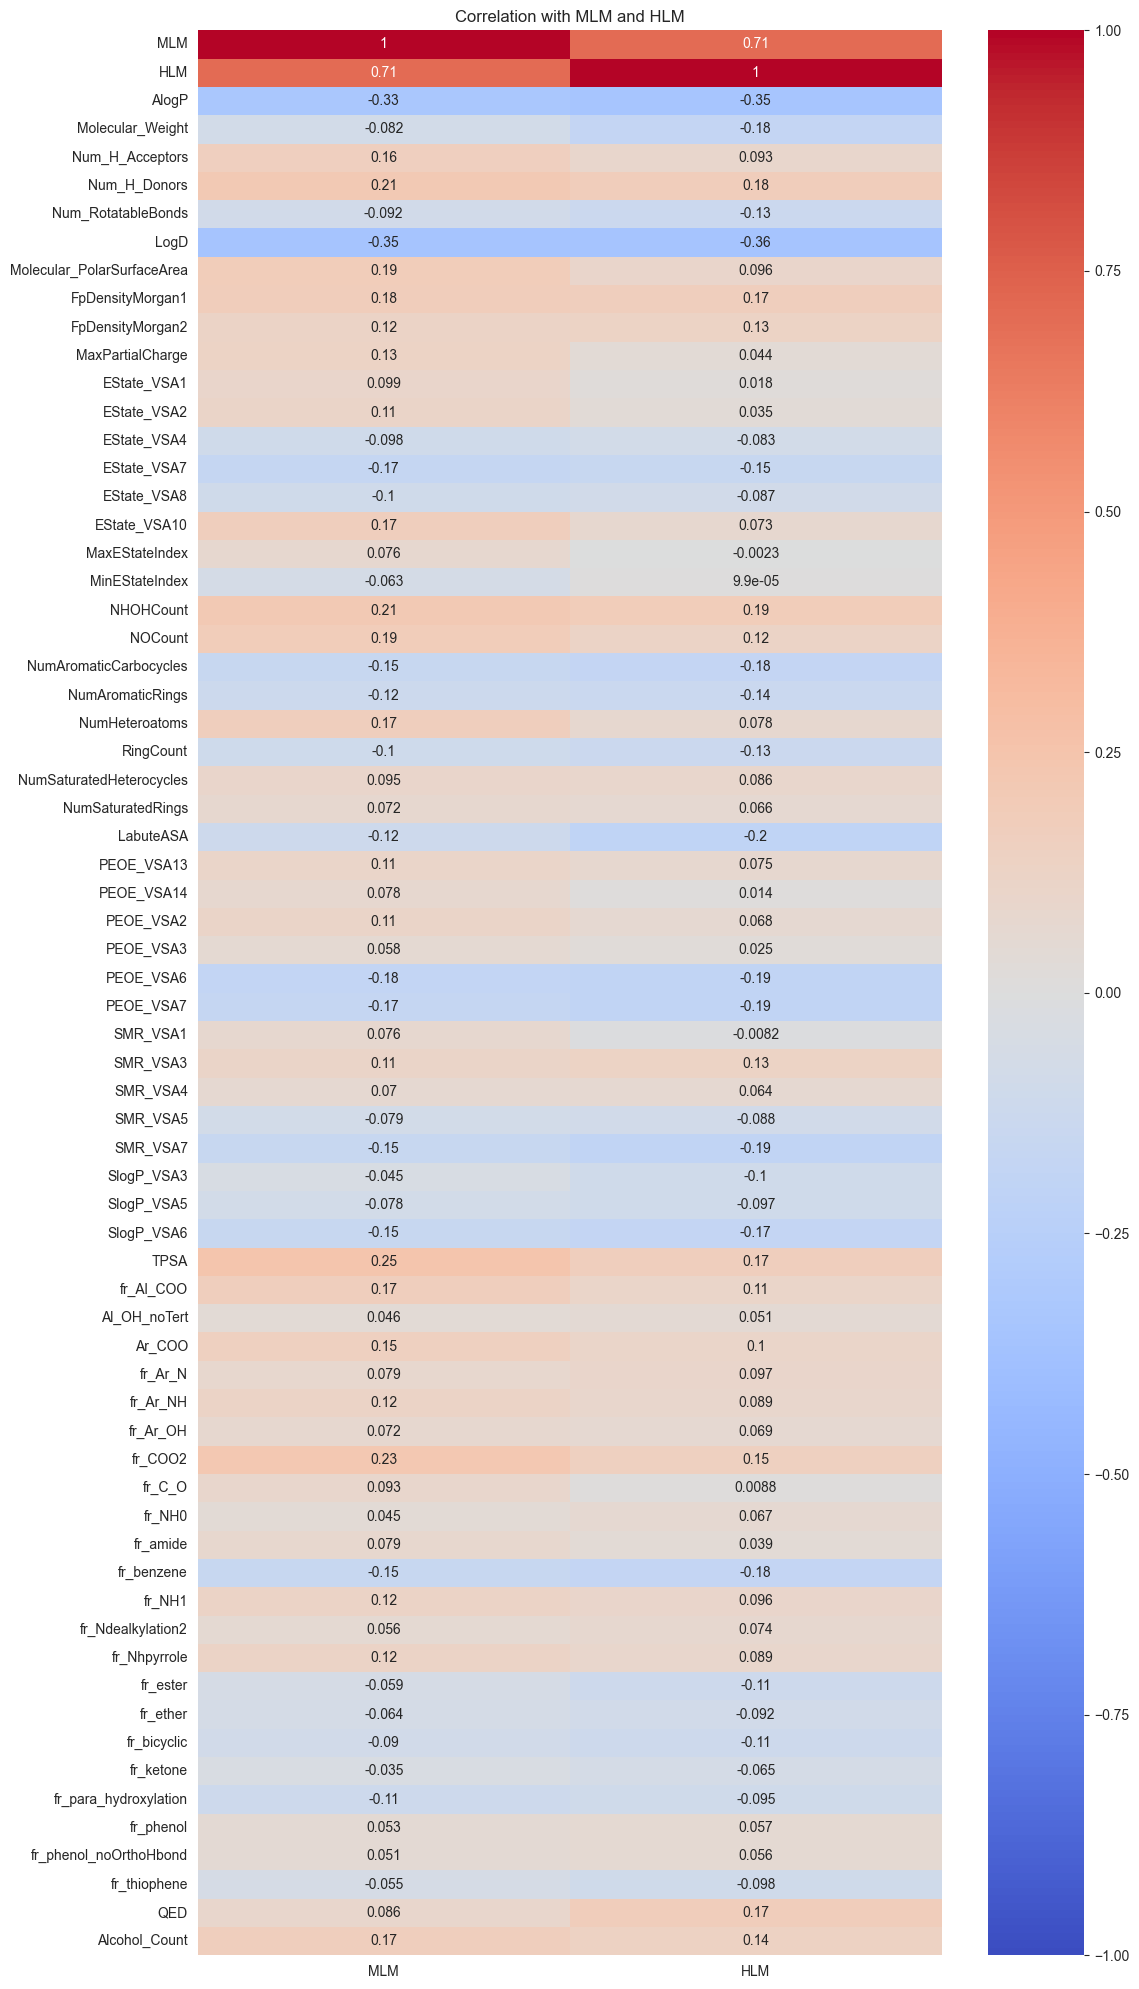

In [29]:
# 상관관계 확인
subset_train = train.drop(columns=['SMILES'])

# Compute correlation with MLM and HLM
correlation_matrix = subset_train.corr(method='pearson')[['MLM', 'HLM']]

# Plot the correlation heatmap
plt.figure(figsize=(12, 25))
sns.heatmap(correlation_matrix[['MLM', 'HLM']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation with MLM and HLM")
plt.show()

In [30]:
# 아래 칼럼 결측값 처리
columns_to_fill = ['MaxPartialCharge']
train[columns_to_fill] = train[columns_to_fill].fillna(0)
test[columns_to_fill] = test[columns_to_fill].fillna(0)

# Verify if there are any missing values left
missing_after_fill = train[train[columns_to_fill].isnull().any(axis=1)]

missing_after_fill[columns_to_fill]

,MaxPartialCharge


In [31]:
knn = KNeighborsRegressor(n_neighbors=10, n_jobs=-1)
bagging = BaggingRegressor(n_estimators=15, n_jobs=-1, random_state=CFG['SEED'])
ets = ExtraTreesRegressor(n_estimators=200, n_jobs=-1, random_state=CFG['SEED'])
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=CFG['SEED'])
xgb = xgb.XGBRegressor(n_estimators=200, n_jobs=-1, random_state=CFG['SEED'])
lgbm = lgb.LGBMRegressor(n_estimators=200, n_jobs=-1, random_state=CFG['SEED'])

In [32]:
def get_stacking_ml_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=CFG['SEED'])
    
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n, y_train_n)):
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred, test_pred_mean

In [33]:
X = train.drop(['SMILES', 'MLM', 'HLM'], axis=1)
y_mlm = train['MLM']
y_hlm = train['HLM']
test = test.drop('SMILES', axis=1)

In [34]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

In [35]:
best_ml = [
    knn, bagging, xgb, lgbm
]

meta_ml_mlm_X_train=[]
meta_ml_mlm_X_test=[]
for estimator in best_ml:

    print(estimator)
    
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, train_scaled, y_mlm, test_scaled, 8)
    
    meta_ml_mlm_X_train.append(temp_X_train)
    meta_ml_mlm_X_test.append(temp_X_test)
    
meta_ml_mlm_X_train=np.hstack(meta_ml_mlm_X_train)
meta_ml_mlm_X_test=np.hstack(meta_ml_mlm_X_test)

meta_ml_mlm_X_train.shape, meta_ml_mlm_X_test.shape

KNeighborsRegressor(n_jobs=-1, n_neighbors=10)
BaggingRegressor(n_estimators=15, n_jobs=-1, random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
LGBMRegressor(n_estimators=200, random_state=42)


((3456, 4), (483, 4))

In [36]:
best_ml = [
    knn, bagging, ets, rf
]

meta_ml_hlm_X_train=[]
meta_ml_hlm_X_test=[]
for estimator in best_ml:

    print(estimator)
    
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, train_scaled, y_mlm, test_scaled, 8)
    
    meta_ml_hlm_X_train.append(temp_X_train)
    meta_ml_hlm_X_test.append(temp_X_test)
    
meta_ml_hlm_X_train=np.hstack(meta_ml_hlm_X_train)
meta_ml_hlm_X_test=np.hstack(meta_ml_hlm_X_test)

meta_ml_hlm_X_train.shape, meta_ml_hlm_X_test.shape

KNeighborsRegressor(n_jobs=-1, n_neighbors=10)
BaggingRegressor(n_estimators=15, n_jobs=-1, random_state=42)
ExtraTreesRegressor(n_estimators=200, n_jobs=-1, random_state=42)
RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)


((3456, 4), (483, 4))

In [37]:
meta_clf_mlm = LinearRegression()
meta_clf_mlm.fit(meta_ml_mlm_X_train, y_mlm)
prediction_mlm = meta_clf_mlm.predict(meta_ml_mlm_X_test)
prediction_mlm.shape

(483,)

In [38]:
meta_clf_hlm = LinearRegression()
meta_clf_hlm.fit(meta_ml_hlm_X_train, y_hlm)
prediction_hlm = meta_clf_hlm.predict(meta_ml_hlm_X_test)
prediction_hlm.shape

(483,)

In [43]:
sample_submission = pd.read_csv('/Users/seunghoonchoi/Downloads/SKKU KDT 2기/공모전/Dacon_making_new_medicine/Data/sample_submission.csv')
sample_submission['MLM'] = np.round(prediction_mlm, 3)
sample_submission['HLM'] = np.round(prediction_hlm, 3)
sample_submission

,id,MLM,HLM
0,TEST_000,31.927,48.974
1,TEST_001,61.486,75.572
2,TEST_002,27.590,45.968
3,TEST_003,51.325,63.281
4,TEST_004,64.385,77.535
...,...,...,...
478,TEST_478,21.011,32.773
479,TEST_479,69.693,80.011
480,TEST_480,37.687,59.056
481,TEST_481,57.773,74.571


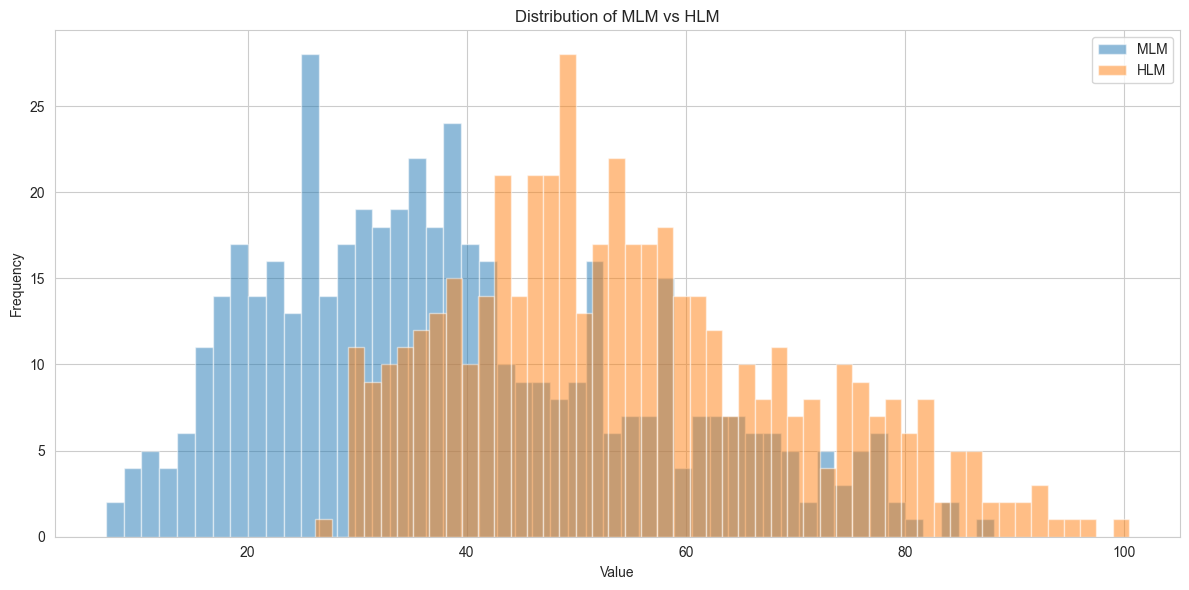

,MLM,HLM
count,483.000000,483.000000
mean,38.858487,54.939774
std,17.123439,15.384029
min,7.071000,26.197000
25%,25.881500,43.496500
50%,36.141000,52.994000
75%,50.585500,64.813500
max,88.153000,100.443000


In [45]:
# 타겟 예측값 살펴보기
desc_stats = sample_submission[['MLM', 'HLM']].describe()

# Plot histograms for MLM and HLM
plt.figure(figsize=(12, 6))

plt.hist(sample_submission['MLM'], bins=50, alpha=0.5, label='MLM')
plt.hist(sample_submission['HLM'], bins=50, alpha=0.5, label='HLM')

plt.title('Distribution of MLM vs HLM')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

desc_stats

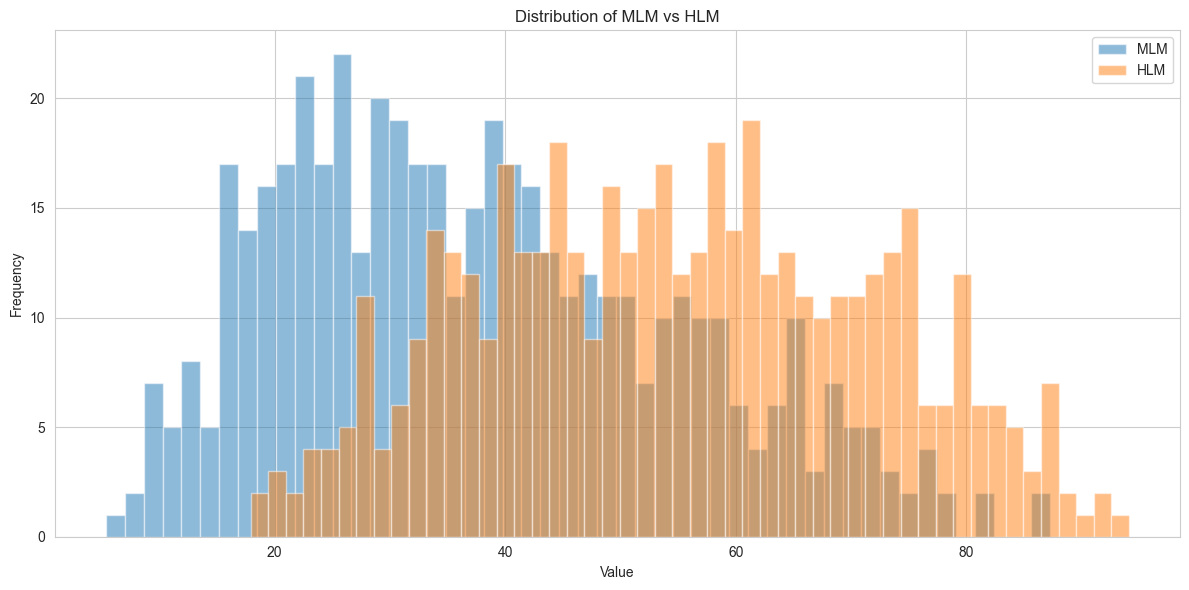

,MLM,HLM
count,483.000000,483.000000
mean,37.779147,54.774257
std,17.167349,16.938008
min,5.352000,17.914000
25%,23.908000,41.211000
50%,35.140000,54.432000
75%,49.536000,67.853000
max,87.302000,94.115000


In [42]:
ens_p = pd.read_csv('/Users/seunghoonchoi/Downloads/SKKU KDT 2기/공모전/Dacon_making_new_medicine/submission/ensemble_submission/ensemble_submission.csv')
desc_stats = ens_p[['MLM', 'HLM']].describe()

# Plot histograms for MLM and HLM
plt.figure(figsize=(12, 6))

plt.hist(ens_p['MLM'], bins=50, alpha=0.5, label='MLM')
plt.hist(ens_p['HLM'], bins=50, alpha=0.5, label='HLM')

plt.title('Distribution of MLM vs HLM')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

desc_stats